In [ ]:
import pickle   #python版的json套件，可將python資料型態的資料進行匯出/匯入
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 擷取網路上練習的capitals.txt做為資料集

data = pd.read_csv('capitals.txt', delimiter=' ')
data.columns = ['city1','country1','city2','country2']
data.head(5)

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


In [ ]:
# 語料庫使用googlenews-vectors
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-01-05 08:26:06--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.90.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.90.94|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 1647046227 (1.5G), 1480026706 (1.4G) remaining [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

   GoogleNews-vecto  13%[++                  ] 213.85M  34.0MB/s               ^C


In [ ]:
# 因為googlenews資料龐大，我們擷取相關的資料來做訓練即可
# 使用KeyedVectors對語料庫進行處理，將其轉換成向量格式
import nltk
from gensim.models import KeyedVectors

embeddings = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary = True)
f = open('capitals.txt', 'r').read()

# 擷取所需字詞，並以集合(set)形式儲存
set_words = set(nltk.word_tokenize(f))
select_words = words = ['king', 'queen', 'oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']
for w in select_words:
    set_words.add(w)

# 定義函式，輸入一語料庫(向量形式)，若其中包含集合中的字詞向量，則存入word_embeddings並回傳
def get_word_embeddings(embeddings):

    word_embeddings = {}
    for word in embeddings.vocab:
        if word in set_words:
            word_embeddings[word] = embeddings[word]
    return word_embeddings

word_embeddings = get_word_embeddings(embeddings)
print(len(word_embeddings))
pickle.dump( word_embeddings, open( "word_embeddings_subset.p", "wb" ) )

FileNotFoundError: ignored

In [ ]:
# 讀取前面匯出的word_embeddings
word_embeddings = pickle.load(open("word_embeddings_subset.p", "rb"))
len(word_embeddings)  # there should be 243 words that will be used in this assignment

# 製作prediction函式
輸入city1、country1與city2，並根據city1←→country1間的關係推測與city2有關的country

使用餘弦判斷兩個向量的相似度

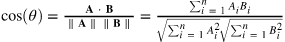

In [ ]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    dot = np.dot(A,B)
    norma = np.sqrt(np.dot(A,A))
    normb = np.sqrt(np.dot(B,B))
    cos = dot / (norma*normb)

    ### END CODE HERE ###
    return cos

使用歐式距離判斷兩個向量的相似度

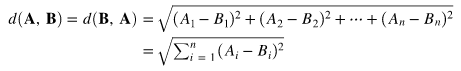

In [ ]:
def euclidean(A, B):
    """
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        d: numerical number representing the Euclidean distance between A and B.
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # euclidean distance

    d = np.linalg.norm(A-B)

    ### END CODE HERE ###

    return d

In [ ]:
def get_country(city1, country1, city2, embeddings):
    """
    Input:
        city1: a string (the capital city of country1)
        country1: a string (the country of capital1)
        city2: a string (the capital city of country2)
        embeddings: a dictionary where the keys are words and values are their embeddings
    Output:
        countries: a dictionary with the most likely country and its similarity score
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # 先將city1,country1,city2存入一個集合
    group = set((city1, country1, city2))

    # 取得其在我們word_embedding的向量
    city1_emb = word_embeddings[city1]
    country1_emb = word_embeddings[country1]
    city2_emb = word_embeddings[city2]

    # 計算country2的理想向量
    # 理論上 city1 - country1 = city2 - country2
    # 所以country2 = country1 - city1 + city2
    vec = country1_emb - city1_emb + city2_emb

    # 初始化相似度，盡可能找到相似度為1的
    similarity = -1

    # 初始化country2
    country = ''

    # 從我們的county名單中逐一檢查其向量與city2的相似度
    for word in embeddings.keys():

        # 找輸入集合外的資料
        if word not in group:

            # 取得該country在word_embedding的向量
            word_emb = word_embeddings[word]

            # 利用餘弦計算兩向量的相似程度
            cur_similarity = cosine_similarity(vec,word_emb)

            # 更新最接近(餘弦值最大，最接近1)的country
            if cur_similarity > similarity:

                # update the similarity to the new, better similarity
                similarity = cur_similarity

                # store the country as a tuple, which contains the word and the similarity
                country = (word, similarity)

    ### END CODE HERE ###

    return country

In [ ]:
# 計算準確度
# 輸入我們製作的word_embeddings,以及capitals.txt的資料(pandas dataframe形式)
# 比對每一列(row)，取出其city1,country1,city2,country2，並呼叫get_country
# 計算預測正確的結果數，並回傳準確度
def get_accuracy(word_embeddings, data):
    '''
    Input:
        word_embeddings: a dictionary where the key is a word and the value is its embedding
        data: a pandas dataframe containing all the country and capital city pairs
    
    Output:
        accuracy: the accuracy of the model
    '''

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # initialize num correct to zero
    num_correct = 0

    # 透過data.iterrows讀取每一row資料
    # 如果要進入這整列資料的某一格，就row[column_name]
    for i, row in data.iterrows():

        # get city1
        city1 = row['city1']

        # get country1
        country1 = row['country1']

        # get city2
        city2 =  row['city2']

        # get country2
        country2 = row['country2']

        # use get_country to find the predicted country2
        predicted_country2, _ = get_country(city1,country1,city2,word_embeddings)

        # if the predicted country2 is the same as the actual country2...
        if predicted_country2 == country2:
            # increment the number of correct by 1
            num_correct += 1

    # get the number of rows in the data dataframe (length of dataframe)
    m = len(data)

    # calculate the accuracy by dividing the number correct by m
    accuracy = num_correct/m

    ### END CODE HERE ###
    return accuracy

# 利用PCA降維
PCA(主成分分析)，是一種透過線性方法，將資料投影到一vector w，使所有資料z的奇異度(Variance)最大。

舉例來說，原本二維的資料，若找一個vector w，使所有資料投影其上，那這些資料就會變成一維(相對於vector w )，如此便可達到降維的目的。

然而我們不希望降維後資料間的差異消失(投影完所有資料都擠在一起就無法區別了)，因此這個w必須要盡可能讓投影得到資料z的奇異度(變異數)最大，在降維的同時仍保持資料的特性

利用此方式，便可將原本的資料投影到任意的維度，但須注意在求每一維度的w時需滿足：
Wm * Wn = 1 
(新維度的w和前一個求出的w內積為0，不設此限制的話你每次求到的最大值w就都一樣了)

要求這些w，相當於求原資料covariance matrix的eigenvector，其中eigenvector有最大的eigenvalue


*   covariance matrix是根據PCA定義(求Max Var(z))中整理出的一部分
*   eigenvector及eigenvalue則可理解為目標矩陣中，不因投影or座標軸改變使得其向量脫離原向量方向的vector & 伸縮的長度
*   用白話文翻譯就是，目標矩陣存在一個「特徵」(eigenvector)，而這個特徵在任何座標軸只會有長度上的差異(eigenvalue)，而不影響特徵本身(不發生旋轉或是變形)



In [ ]:
def compute_pca(X, n_components=2):
    """
    Input:
        X: 我們的word vector
        n_components: 要降成幾維
    Output:
        X_reduced: 降成目標維度的資料
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # 求Var(X) (以矩陣表示)
    X_demeaned = X - np.mean(X,axis=0)
    print('X_demeaned.shape: ',X_demeaned.shape)
    
    # 計算Cov(X)
    covariance_matrix = np.cov(X_demeaned, rowvar=False)

    # 計算eigenvector、eigenvalue
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix, UPLO='L')
    
    # 由大到小排序eigenvalue的index，再用這些index排序出由大到小的eigenvalue
    idx_sorted = np.argsort(eigen_vals)  
    idx_sorted_decreasing = idx_sorted[::-1]
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

    # 同理，利用這些index排序出對應順序的eigenvector
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]

    # 根據你要的維度數，選擇前n個eigenvector
    eigen_vecs_subset = eigen_vecs_sorted[:,0:n_components]

    # 將降維的結果回傳
    # Z = wx
    X_reduced = np.dot(eigen_vecs_subset.transpose(),X_demeaned.transpose()).transpose()

    ### END CODE HERE ###

    return X_reduced